# Homework 2: Two ways with MIMIC-III
### Jonathan Wu
### Due: 5/9/2025

#### Part I (Relational)
1. Load all the data into a duckdb database. Refer to MIMIC-III example for guidance to create your own database.
2. Answer the following analysis questions along with your queries.
For each question, provide the following four pieces of information:
<br>a. the SQL query,
<br>b. brief explanation of the query (i.e., what operations are performed by the major parts of the query),
<br>c. the first several lines of your resulting table, and
<br>d. a summary of your findings. If it benefits to use a graph, include your graph at the end of your answer, with clear labels and caption.

The analysis questions are:

1. Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.
2. Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.
3. How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

In [1]:
#!pip install duckdb==1.2.2
import duckdb
import pandas as pd

In [2]:
conn = duckdb.connect('mimic2.db', read_only=False)

conn.sql('SHOW TABLES;')

┌───────────────┐
│     name      │
│    varchar    │
├───────────────┤
│ ADMISSIONS    │
│ DRGCODES      │
│ D_ICD         │
│ ICUSTAYS      │
│ PATIENTS      │
│ PRESCRIPTIONS │
│ PROD_ICD      │
└───────────────┘

In [5]:
files = ["ADMISSIONS", "D_ICD_PROCEDURES", 'DRGCODES','ICUSTAYS','PATIENTS', 'PRESCRIPTIONS', 'PROCEDURES_ICD']
file_name = ['ADMISSIONS', 'D_ICD', 'DRGCODES','ICUSTAYS','PATIENTS','PRESCRIPTIONS','PROD_ICD']
for i in range(len(files)):
    try:
        df = pd.read_csv("hw2 files/"+files[i]+".csv")#, index_col="row_id")
        df.to_sql(file_name[i], conn, index=False)
    except:
        continue

C:\Users\wujon\AppData\Local\Temp\ipykernel_23700\3787481121.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df.to_sql(file_name[i], conn, index=False)
C:\Users\wujon\AppData\Local\Temp\ipykernel_23700\3787481121.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df.to_sql(file_name[i], conn, index=False)
C:\Users\wujon\AppData\Local\Temp\ipykernel_23700\3787481121.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df.to_sql(file_name[i], conn, index=False)
C:\Users\wujon\AppData\Local\Temp\ipykernel_23700\3787481121.

In [6]:
conn.close()

In [7]:
conn = duckdb.connect('mimic.db')

conn.sql('SHOW TABLES;')

┌───────────────┐
│     name      │
│    varchar    │
├───────────────┤
│ ADMISSIONS    │
│ DRGCODES      │
│ D_ICD         │
│ ICUSTAYS      │
│ PATIENTS      │
│ PRESCRIPTIONS │
│ PROD_ICD      │
└───────────────┘

In [8]:
conn.sql(
    """
    SELECT * FROM PRESCRIPTIONS LIMIT 2;
    """
)

┌────────────┬─────────┬────────────┬─────────────────────┬─────────────────────┬───────────┬─────────────────────────────┬─────────────────────────────┬─────────────────────────────┬───────────────────┬─────────┬─────────────┬──────────────────┬─────────────┬──────────────┬───────────────┬────────────────┬─────────┐
│ subject_id │ hadm_id │ icustay_id │      startdate      │       enddate       │ drug_type │            drug             │        drug_name_poe        │      drug_name_generic      │ formulary_drug_cd │   gsn   │     ndc     │  prod_strength   │ dose_val_rx │ dose_unit_rx │ form_val_disp │ form_unit_disp │  route  │
│   int32    │  int32  │   float    │       varchar       │       varchar       │  varchar  │           varchar           │           varchar           │           varchar           │      varchar      │  float  │    float    │     varchar      │   varchar   │   varchar    │    varchar    │    varchar     │ varchar │
├────────────┼─────────┼────────────┼──────

#### Part I Question 1
Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.

In [9]:
conn.sql(
    """
    SELECT ethnicity, drug, dose_val_rx, dose_unit_rx, count(drug) as prescription_count
    FROM ADMISSIONS
    JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
    GROUP BY ethnicity, drug, dose_val_rx, dose_unit_rx
    ORDER BY prescription_count DESC
    LIMIT 5;
    """
)

┌────────────────────────────────┬──────────────────────────────────────┬─────────────┬──────────────┬────────────────────┐
│           ethnicity            │                 drug                 │ dose_val_rx │ dose_unit_rx │ prescription_count │
│            varchar             │               varchar                │   varchar   │   varchar    │       int64        │
├────────────────────────────────┼──────────────────────────────────────┼─────────────┼──────────────┼────────────────────┤
│ HISPANIC/LATINO - PUERTO RICAN │ 0.9% Sodium Chloride (Mini Bag Plus) │ 100         │ mL           │                465 │
│ HISPANIC/LATINO - PUERTO RICAN │ 0.9% Sodium Chloride                 │ 1000        │ mL           │                420 │
│ HISPANIC/LATINO - PUERTO RICAN │ Potassium Chloride                   │ 40          │ mEq          │                390 │
│ HISPANIC/LATINO - PUERTO RICAN │ Insulin                              │ 0           │ UNIT         │                375 │
│ HISPAN

Going to need to grab admissions for ethnicity and prescriptions

https://www.geeksforgeeks.org/how-to-select-the-first-row-of-each-group-by-in-sql/

In [10]:
conn.sql(
    """
    SELECT ethnicity, drug, dose_val_rx, dose_unit_rx, prescription_count
    FROM (
        SELECT
            ADMISSIONS.ethnicity,
            PRESCRIPTIONS.drug,
            PRESCRIPTIONS.dose_val_rx,
            PRESCRIPTIONS.dose_unit_rx,
            COUNT(*) AS prescription_count,
            ROW_NUMBER() OVER (
                PARTITION BY ADMISSIONS.ethnicity
                ORDER BY COUNT(*) DESC
            ) AS rank
        FROM ADMISSIONS
        JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
        GROUP BY
            ADMISSIONS.ethnicity,
            PRESCRIPTIONS.drug,
            PRESCRIPTIONS.dose_val_rx,
            PRESCRIPTIONS.dose_unit_rx
    )
    WHERE rank = 1
    ORDER BY ethnicity;
    """
)


┌──────────────────────────────────────────────────────────┬──────────────────────────────────────┬─────────────┬──────────────┬────────────────────┐
│                        ethnicity                         │                 drug                 │ dose_val_rx │ dose_unit_rx │ prescription_count │
│                         varchar                          │               varchar                │   varchar   │   varchar    │       int64        │
├──────────────────────────────────────────────────────────┼──────────────────────────────────────┼─────────────┼──────────────┼────────────────────┤
│ AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE │ 5% Dextrose                          │ 1000        │ mL           │                 30 │
│ ASIAN                                                    │ D5W                                  │ 250         │ ml           │                 14 │
│ BLACK/AFRICAN AMERICAN                                   │ Insulin                              │ 

In [11]:
df1 = conn.sql(
    """
    SELECT
        ADMISSIONS.ethnicity,
        PRESCRIPTIONS.drug,
        count(*) as amount
    FROM ADMISSIONS
    JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
    GROUP BY ADMISSIONS.ethnicity, PRESCRIPTIONS.drug
    ORDER BY ethnicity, amount DESC;
    """
).df()
df1


,ethnicity,drug,amount
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,54
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,0.9% Sodium Chloride,44
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Potassium Chloride,42
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Lactulose,26
4,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Albumin 25% (12.5g / 50mL),22
...,...,...,...
1255,WHITE,Lidocaine 1%/Epinephrine 1:100000,1
1256,WHITE,Moexipril HCl,1
1257,WHITE,Benzocaine 20% Spray,1
1258,WHITE,Promethazine,1


In [12]:
df = conn.sql(
    """
    SELECT
    ETHNICITY,DRUG,AMOUNT
FROM (
    SELECT
        ADMISSIONS.ETHNICITY,
        PRESCRIPTIONS.DRUG,
        COUNT(*) AS AMOUNT
    FROM PRESCRIPTIONS
    JOIN ADMISSIONS ON PRESCRIPTIONS.subject_id = ADMISSIONS.subject_id
    GROUP BY ADMISSIONS.ETHNICITY, PRESCRIPTIONS.DRUG
) AS counts
QUALIFY AMOUNT = MAX(AMOUNT) OVER (PARTITION BY ETHNICITY)
ORDER BY ETHNICITY;
    """
).df()
df


,ethnicity,drug,AMOUNT
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,54
1,ASIAN,D5W,27
2,BLACK/AFRICAN AMERICAN,Insulin,60
3,HISPANIC OR LATINO,5% Dextrose,28
4,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,1290
5,OTHER,NS,11
6,UNABLE TO OBTAIN,0.9% Sodium Chloride,28
7,UNKNOWN/NOT SPECIFIED,D5W,41
8,WHITE,Potassium Chloride,508


Note: you may need to restart the kernel to use updated packages.


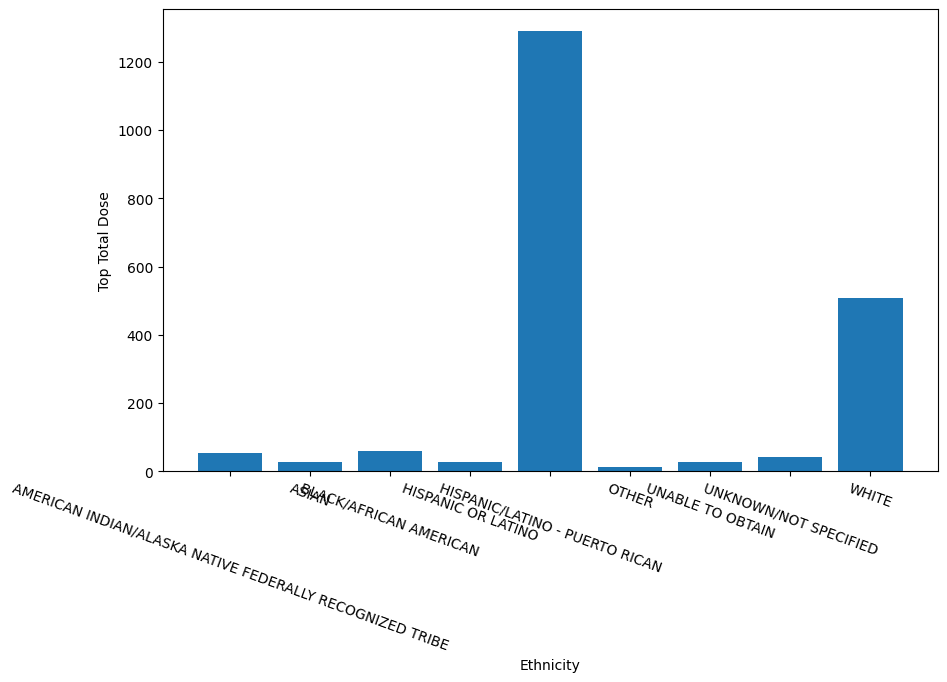

In [16]:
%pip install matplotlib
import matplotlib.pyplot as plt

top_doses = df.groupby('ethnicity')['AMOUNT'].max().reset_index()
plt.figure(figsize=(10,6))
plt.bar(top_doses['ethnicity'], top_doses['AMOUNT'])
plt.xlabel("Ethnicity")
plt.ylabel("Top Total Dose")
plt.xticks(rotation = -20)
plt.show()

#### Part I Question 2
Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.

In [ ]:
conn.sql(
    """
    SELECT * FROM PATIENTS LIMIT 2;
    """
)

┌────────┬────────────┬─────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────┐
│ row_id │ subject_id │ gender  │         dob         │         dod         │      dod_hosp       │       dod_ssn       │ expire_flag │
│ int32  │   int32    │ varchar │       varchar       │       varchar       │       varchar       │       varchar       │    int32    │
├────────┼────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────┤
│   9467 │      10006 │ F       │ 2094-03-05 00:00:00 │ 2165-08-12 00:00:00 │ 2165-08-12 00:00:00 │ 2165-08-12 00:00:00 │           1 │
│   9472 │      10011 │ F       │ 2090-06-05 00:00:00 │ 2126-08-28 00:00:00 │ 2126-08-28 00:00:00 │ NULL                │           1 │
└────────┴────────────┴─────────┴─────────────────────┴─────────────────────┴─────────────────────┴─────────────────────┴─────────────┘

In [ ]:
conn.sql(
    """
    SELECT * FROM ADMISSIONS LIMIT 2;
    """
)

┌────────┬────────────┬─────────┬─────────────────────┬─────────────────────┬─────────────────────┬────────────────┬───────────────────────────┬────────────────────┬───────────┬──────────┬──────────┬────────────────┬────────────────────────┬─────────────────────┬─────────────────────┬─────────────┬──────────────────────┬──────────────────────┐
│ row_id │ subject_id │ hadm_id │      admittime      │      dischtime      │      deathtime      │ admission_type │    admission_location     │ discharge_location │ insurance │ language │ religion │ marital_status │       ethnicity        │      edregtime      │      edouttime      │  diagnosis  │ hospital_expire_flag │ has_chartevents_data │
│ int32  │   int32    │  int32  │       varchar       │       varchar       │       varchar       │    varchar     │          varchar          │      varchar       │  varchar  │ varchar  │ varchar  │    varchar     │        varchar         │       varchar       │       varchar       │   varchar   │        i

In [ ]:
conn.sql(
    """
    SELECT * FROM PROCS_ICD LIMIT 2;
    """
)

┌────────┬────────────┬─────────┬─────────┬───────────┐
│ row_id │ subject_id │ hadm_id │ seq_num │ icd9_code │
│ int32  │   int32    │  int32  │  int32  │   int32   │
├────────┼────────────┼─────────┼─────────┼───────────┤
│   3994 │      10114 │  167957 │       1 │      3605 │
│   3995 │      10114 │  167957 │       2 │      3722 │
└────────┴────────────┴─────────┴─────────┴───────────┘

In [ ]:
conn.sql(
    """
    SELECT * FROM D_ICDPROCS LIMIT 2;
    """
)

┌────────┬───────────┬──────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ row_id │ icd9_code │       short_title        │                            long_title                             │
│ int32  │   int32   │         varchar          │                              varchar                              │
├────────┼───────────┼──────────────────────────┼───────────────────────────────────────────────────────────────────┤
│      1 │      1423 │ Chorioret les xenon coag │ Destruction of chorioretinal lesion by xenon arc photocoagulation │
│      2 │      1424 │ Chorioret les laser coag │ Destruction of chorioretinal lesion by laser photocoagulation     │
└────────┴───────────┴──────────────────────────┴───────────────────────────────────────────────────────────────────┘

In [ ]:
conn.sql(
    """
    SELECT date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) as age
    FROM PATIENTS
    JOIN ADMISSIONS ON PATIENTS.subject_id=ADMISSIONS.subject_id
    LIMIT 10;
    """
)

┌───────┐
│  age  │
│ int64 │
├───────┤
│    70 │
│    36 │
│    87 │
│    74 │
│    49 │
│   300 │
│    82 │
│    78 │
│    88 │
│    81 │
└───────┘

In [ ]:
conn.sql(
    """
    SELECT CASE
    WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
    WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <50 THEN 'ADULT'
    WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >=50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
    ELSE 'ELDERLY'
    END AS age_group,
    long_title,
    FROM PATIENTS
    JOIN ADMISSIONS ON PATIENTS.subject_id=ADMISSIONS.subject_id
    JOIN PROCS_ICD ON ADMISSIONS.hadm_id=PROCS_ICD.hadm_id
    JOIN D_ICDPROCS ON PROCS_ICD.ICD9_CODE=D_ICDPROCS.ICD9_CODE
    GROUP BY age_group
    LIMIT 5;
    """
)

┌───────────┬─────────────────────────────────────────────────────────────────────────────┬─────────────────┐
│ age_group │                                 long_title                                  │ procedure_count │
│  varchar  │                                   varchar                                   │      int64      │
├───────────┼─────────────────────────────────────────────────────────────────────────────┼─────────────────┤
│ ADULT     │ Venous catheterization, not elsewhere classified                            │               9 │
│ ADULT     │ Enteral infusion of concentrated nutritional substances                     │               7 │
│ ADULT     │ Insertion of endotracheal tube                                              │               6 │
│ ADULT     │ Percutaneous abdominal drainage                                             │               6 │
│ ADULT     │ Continuous invasive mechanical ventilation for 96 consecutive hours or more │               6 │
└─────────

In [179]:
df2 = conn.sql(
    """
    SELECT *
    FROM (
        SELECT
            CASE
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 50 THEN 'ADULT'
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
                ELSE 'ELDERLY'
            END AS age_group,
            long_title,
            COUNT(*) AS procedure_count,
            ROW_NUMBER() OVER (
                PARTITION BY
                    CASE
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 50 THEN 'ADULT'
                        WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
                        ELSE 'ELDERLY'
                    END
                ORDER BY COUNT(*) DESC
            ) AS rank
        FROM PATIENTS
        JOIN ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
        JOIN PROD_ICD ON ADMISSIONS.hadm_id = PROD_ICD.hadm_id
        JOIN D_ICD ON PROD_ICD.ICD9_CODE = D_ICD.ICD9_CODE
        GROUP BY age_group, long_title
    ) ranked
    WHERE rank <= 3
    ORDER BY age_group, procedure_count DESC;
    """
).df()
df2

,age_group,long_title,procedure_count,rank
0,ADULT,"Venous catheterization, not elsewhere classified",9,1
1,ADULT,Enteral infusion of concentrated nutritional s...,7,2
2,ADULT,Percutaneous abdominal drainage,6,3
3,ELDERLY,"Venous catheterization, not elsewhere classified",20,1
4,ELDERLY,Transfusion of packed cells,13,2
5,ELDERLY,Insertion of endotracheal tube,8,3
6,MINOR,"Venous catheterization, not elsewhere classified",2,1
7,MINOR,Interruption of the vena cava,1,2
8,MINOR,Closure of skin and subcutaneous tissue of oth...,1,3
9,OLD,"Venous catheterization, not elsewhere classified",25,1


#### Part I Question 3
How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

https://duckdb.org/docs/stable/sql/data_types/typecasting

https://duckdb.org/docs/stable/sql/data_types/interval

https://duckdb.org/docs/stable/sql/functions/datepart.html

https://duckdb.org/docs/stable/sql/functions/interval.html

In [ ]:
conn.sql(
    """
    SELECT * FROM PATIENTS LIMIT 5;
    """
)

┌────────┬────────────┬─────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────┐
│ row_id │ subject_id │ gender  │         dob         │         dod         │      dod_hosp       │       dod_ssn       │ expire_flag │
│ int32  │   int32    │ varchar │       varchar       │       varchar       │       varchar       │       varchar       │    int32    │
├────────┼────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────┤
│   9467 │      10006 │ F       │ 2094-03-05 00:00:00 │ 2165-08-12 00:00:00 │ 2165-08-12 00:00:00 │ 2165-08-12 00:00:00 │           1 │
│   9472 │      10011 │ F       │ 2090-06-05 00:00:00 │ 2126-08-28 00:00:00 │ 2126-08-28 00:00:00 │ NULL                │           1 │
│   9474 │      10013 │ F       │ 2038-09-03 00:00:00 │ 2125-10-07 00:00:00 │ 2125-10-07 00:00:00 │ 2125-10-07 00:00:00 │           1 │
│   9478 │      10017 │ F       │ 2075-09-21 00:

In [ ]:
conn.sql("""
SELECT * FROM ICUSTAYS LIMIT 5""")

┌────────┬────────────┬─────────┬────────────┬──────────┬────────────────┬───────────────┬──────────────┬─────────────┬─────────────────────┬─────────────────────┬─────────┐
│ row_id │ subject_id │ hadm_id │ icustay_id │ dbsource │ first_careunit │ last_careunit │ first_wardid │ last_wardid │       intime        │       outtime       │   los   │
│ int32  │   int32    │  int32  │   int32    │ varchar  │    varchar     │    varchar    │    int32     │    int32    │       varchar       │       varchar       │  float  │
├────────┼────────────┼─────────┼────────────┼──────────┼────────────────┼───────────────┼──────────────┼─────────────┼─────────────────────┼─────────────────────┼─────────┤
│  12742 │      10006 │  142345 │     206504 │ carevue  │ MICU           │ MICU          │           52 │          52 │ 2164-10-23 21:10:15 │ 2164-10-25 12:21:07 │  1.6325 │
│  12747 │      10011 │  105331 │     232110 │ carevue  │ MICU           │ MICU          │           15 │          15 │ 2126-08-14

In [ ]:
conn.sql("""
SELECT avg(epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP)))/3600 AS remaining_hours
FROM ICUSTAYS""")

┌────────────────────┐
│  remaining_hours   │
│       double       │
├────────────────────┤
│ 106.85906658496732 │
└────────────────────┘

In [ ]:
conn.sql("""
SELECT gender, avg(epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP)))/3600 AS remaining_hours
FROM ICUSTAYS JOIN PATIENTS on ICUSTAYS.subject_id=PATIENTS.subject_id GROUP BY gender""")

┌─────────┬────────────────────┐
│ gender  │  remaining_hours   │
│ varchar │       double       │
├─────────┼────────────────────┤
│ F       │ 132.96187389770722 │
│ M       │  84.33198630136985 │
└─────────┴────────────────────┘

In [ ]:
conn.sql("""
SELECT ethnicity, avg(epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP)))/3600 AS remaining_hours
FROM ICUSTAYS JOIN ADMISSIONS on ICUSTAYS.subject_id=ADMISSIONS.subject_id GROUP BY ethnicity""")

┌──────────────────────────────────────────────────────────┬────────────────────┐
│                        ethnicity                         │  remaining_hours   │
│                         varchar                          │       double       │
├──────────────────────────────────────────────────────────┼────────────────────┤
│ BLACK/AFRICAN AMERICAN                                   │  164.8246296296296 │
│ UNKNOWN/NOT SPECIFIED                                    │ 108.25615384615385 │
│ OTHER                                                    │ 22.225740740740743 │
│ ASIAN                                                    │           93.36125 │
│ HISPANIC OR LATINO                                       │  179.0312962962963 │
│ WHITE                                                    │  98.95345400728597 │
│ HISPANIC/LATINO - PUERTO RICAN                           │  77.83348148148148 │
│ UNABLE TO OBTAIN                                         │ 320.56888888888886 │
│ AMERICAN INDIA

In [182]:
df3= conn.sql("""
SELECT ethnicity, gender, avg(epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP)))/3600 AS hospise_time
FROM ICUSTAYS 
JOIN PATIENTS on ICUSTAYS.subject_id=PATIENTS.subject_id
JOIN ADMISSIONS on ICUSTAYS.subject_id=ADMISSIONS.subject_id GROUP BY ethnicity, gender""").df()
df3

,ethnicity,gender,hospise_time
0,BLACK/AFRICAN AMERICAN,F,268.829792
1,HISPANIC OR LATINO,F,179.031296
2,WHITE,M,83.012210
3,UNKNOWN/NOT SPECIFIED,M,51.491389
4,ASIAN,M,170.815278
5,ASIAN,F,15.907222
6,HISPANIC/LATINO - PUERTO RICAN,M,77.833481
7,OTHER,F,32.067500
8,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,M,272.091806
9,OTHER,M,2.542222


## Part 2


In [8]:
!curl https://certs.secureserver.net/repository/sf-class2-root.crt -O

'curl' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(
    region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

C:\Users\wujon\AppData\Local\Temp\ipykernel_48288\1196366822.py:7: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


In [10]:
# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142)  # TLS only communicates on port 9142
# establishing connection to Keyspace
session = cluster.connect()

### Part 1

In [11]:
# For example, create a keyspace for HW2
r = session.execute('''
    CREATE KEYSPACE IF NOT EXISTS part1 
    WITH replication = {'class': 'SingleRegionStrategy'};
    ''')
print(r.current_rows)

[]


In [12]:
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel


# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()
session.set_keyspace('part1')  # Replace with your keyspace

In [84]:
part1 = conn.sql("""
SELECT ADMISSIONS.subject_id, ADMISSIONS.hadm_id, ethnicity, drug FROM ADMISSIONS
JOIN PRESCRIPTIONS ON ADMISSIONS.subject_id = PRESCRIPTIONS.subject_id
""").df()
part1.shape

(29741, 4)

In [85]:
part1.head()

,subject_id,hadm_id,ethnicity,drug
0,42458,159647,WHITE,Pneumococcal Vac Polyvalent
1,42458,159647,WHITE,Bisacodyl
2,42458,159647,WHITE,Bisacodyl
3,42458,159647,WHITE,Senna
4,42458,159647,WHITE,Docusate Sodium (Liquid)


In [92]:
session.execute("""
CREATE TABLE IF NOT EXISTS drug_usage_by_ethnicity1 (
    ethnicity TEXT,
    drug TEXT,
    usage_id INT, 
    PRIMARY KEY ((ethnicity), drug, usage_id)
);
""")

In [ ]:
prepared = session.prepare("""
    INSERT INTO drug_usage_by_ethnicity1 (ethnicity, drug, usage_id)
    VALUES (?, ?, ?)
""")

for i, row in part1.iterrows():
    session.execute(prepared, (row['ethnicity'], row['drug'], i))

In [102]:
rows = session.execute("SELECT ethnicity FROM drug_usage_by_ethnicity1")
ethnicity_list = list(set(row.ethnicity for row in rows))

records = []

for eth in ethnicity_list:
    rows = session.execute("""
        SELECT drug FROM drug_usage_by_ethnicity1 WHERE ethnicity = %s
    """, [eth])
    
    # Convert rows to DataFrame
    df_eth = pd.DataFrame(rows)
    

    # Group by drug and count
    df_grouped = (
        df_eth.groupby('drug')
        .size()
        .reset_index(name='amount')
        .sort_values('amount', ascending=False)
    )
    
    # Select top row (most frequent drug)
    top_row = df_grouped.iloc[0]
    records.append({
        'ETHNICITY': eth,
        'DRUG': top_row['drug'],
        'AMOUNT': top_row['amount']
    })

# Final result
df_top_drugs = pd.DataFrame(records)

df_top_drugs

,ETHNICITY,DRUG,AMOUNT
0,HISPANIC OR LATINO,5% Dextrose,28
1,UNABLE TO OBTAIN,0.9% Sodium Chloride,28
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,54
3,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,1290
4,UNKNOWN/NOT SPECIFIED,D5W,41
5,OTHER,NS,11
6,BLACK/AFRICAN AMERICAN,Insulin,60
7,WHITE,Potassium Chloride,508
8,ASIAN,D5W,27


### Part 2

In [175]:
session.execute("""
CREATE TABLE IF NOT EXISTS question24 (
    procedure_name TEXT,
    age TEXT,
    ID INT,
    PRIMARY KEY ((age), procedure_name, ID)
);
""")

In [157]:
part2 = conn.sql("""
SELECT
        CASE
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) <= 19 THEN 'MINOR'
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 20 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 50 THEN 'ADULT'
                WHEN date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) >= 50 AND date_diff('year', cast(dob as DATE), cast(dischtime as DATE)) < 80 THEN 'OLD'
                ELSE 'ELDERLY'
        END AS age_group,
        D_ICD.LONG_TITLE as PROCEDURE_NAME,
        PROD_ICD.hadm_id as PROCS_ID,
        ADMISSIONS.subject_id as ADM_ID,
        PATIENTS.dod as PATIENTS_ID,
        D_ICD.icd9_code as D_ICD_ID
FROM PATIENTS
        JOIN ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
        JOIN PROD_ICD ON ADMISSIONS.hadm_id = PROD_ICD.hadm_id
        JOIN D_ICD ON PROD_ICD.ICD9_CODE = D_ICD.ICD9_CODE""").df()
part2.head()

,age_group,PROCEDURE_NAME,PROCS_ID,ADM_ID,PATIENTS_ID,D_ICD_ID
0,OLD,Other operations on extraocular muscles and te...,133110,10046,2195-03-13 00:00:00,159
1,ADULT,Transplant from cadaver,160445,10126,2171-08-16 00:00:00,93
2,ADULT,Other diagnostic procedures on brain and cereb...,180685,10098,2170-12-03 00:00:00,118
3,ADULT,Administration of inhaled nitric oxide,160445,10126,2171-08-16 00:00:00,12
4,ADULT,Injection or infusion of nesiritide,160445,10126,2171-08-16 00:00:00,13


In [165]:
part2.shape

(516, 6)

In [ ]:
prepared = session.prepare("""
    INSERT INTO question24 (procedure_name, AGE, ID)
    VALUES (?, ?, ?)
""")

for i, row in part2.iterrows():
    session.execute(prepared, (row.PROCEDURE_NAME, row.age_group, i))

In [177]:
# Step 1: Fetch all data (procedure_name and age_group)
rows = session.execute("SELECT procedure_name, AGE FROM question24")

# Step 2: Convert the result into a DataFrame
df = pd.DataFrame(rows)

df

,procedure_name,age
0,"Application of external fixator device, femur",MINOR
1,Atlas-axis spinal fusion,MINOR
2,Closed [endoscopic] biopsy of bronchus,MINOR
3,Closed reduction of fracture without internal ...,MINOR
4,Closure of skin and subcutaneous tissue of oth...,MINOR
...,...,...
511,"Venous catheterization, not elsewhere classified",OLD
512,"Venous catheterization, not elsewhere classified",OLD
513,"Venous catheterization, not elsewhere classified",OLD
514,"Venous catheterization, not elsewhere classified",OLD


In [178]:
rows = session.execute("SELECT AGE FROM question24")
age_list = list(set(row.age for row in rows))

records = []

for age in age_list:
    rows = session.execute("""
        SELECT procedure_name FROM question24 WHERE age = %s
    """, [age])
    
    # Convert rows to DataFrame
    df_eth = pd.DataFrame(rows)
    

    # Group by drug and count
    df_grouped = (
        df_eth.groupby('procedure_name')
        .size()
        .reset_index(name='amount')
        .sort_values('amount', ascending=False)
    )
    
    top_3_rows = df_grouped.head(3)  # Get the top 3 procedures
    
    for _, row in top_3_rows.iterrows():
        records.append({
            'age': age,  # Or 'AGE' if you are doing age group
            'procedure_name': row['procedure_name'],
            'AMOUNT': row['amount']
        })

# Final result
df_proceds = pd.DataFrame(records)

df_proceds

,age,procedure_name,AMOUNT
0,ADULT,"Venous catheterization, not elsewhere classified",9
1,ADULT,Enteral infusion of concentrated nutritional s...,7
2,ADULT,Insertion of endotracheal tube,6
3,ELDERLY,"Venous catheterization, not elsewhere classified",20
4,ELDERLY,Transfusion of packed cells,13
5,ELDERLY,Insertion of endotracheal tube,8
6,OLD,"Venous catheterization, not elsewhere classified",25
7,OLD,Enteral infusion of concentrated nutritional s...,22
8,OLD,Transfusion of packed cells,13
9,MINOR,"Venous catheterization, not elsewhere classified",2


### Part 3

In [117]:
part3= conn.sql("""
SELECT ethnicity, 
                gender, 
                epoch(cast(outtime as TIMESTAMP) - cast(intime as TIMESTAMP))/3600 AS hospise_time
FROM ICUSTAYS 
JOIN PATIENTS on ICUSTAYS.subject_id=PATIENTS.subject_id
JOIN ADMISSIONS on ICUSTAYS.subject_id=ADMISSIONS.subject_id""").df()
part3

,ethnicity,gender,hospise_time
0,BLACK/AFRICAN AMERICAN,F,39.181111
1,UNKNOWN/NOT SPECIFIED,F,332.416667
2,UNKNOWN/NOT SPECIFIED,F,63.597778
3,WHITE,F,51.446667
4,WHITE,M,31.052222
...,...,...,...
377,HISPANIC/LATINO - PUERTO RICAN,M,18.164722
378,HISPANIC/LATINO - PUERTO RICAN,M,31.509722
379,HISPANIC/LATINO - PUERTO RICAN,M,24.421389
380,HISPANIC/LATINO - PUERTO RICAN,M,46.694722


In [ ]:
session.execute("""
CREATE TABLE IF NOT EXISTS question31 (
    ethnicity TEXT,
    gender TEXT,
    hospise_time FLOAT,
    id INT,
    PRIMARY KEY ((ethnicity), gender, hospise_time, id)
);
""")

In [194]:
prepared = session.prepare("""
    INSERT INTO question31 (ethnicity, gender, hospise_time, id)
    VALUES (?, ?, ?,?)
""")

for i, row in part3.iterrows():
    session.execute(prepared, (row['ethnicity'], row['gender'], row['hospise_time'], i))

In [195]:
rows = session.execute("""SELECT ethnicity, hospise_time FROM question31 where ethnicity = 'OTHER'""")
df = pd.DataFrame(rows)
df

,ethnicity,hospise_time
0,OTHER,18.245556
1,OTHER,45.889446
2,OTHER,2.542222


In [196]:
rows = session.execute("""SELECT ethnicity FROM question31""")
ethnicity_list = list(set(row.ethnicity for row in rows))

records = []

for eth in ethnicity_list:
    rows = session.execute("""SELECT gender FROM question31 WHERE ethnicity = %s""", [eth])
    gender_list = list(set(row.gender for row in rows))
    for gen in gender_list:
        # Filter the DataFrame for each group
        rows = session.execute("""
        SELECT hospise_time FROM question31 WHERE ethnicity = %s AND gender = %s
        """, [eth, gen])

        df_eth = pd.DataFrame(rows)
        if not df_eth.empty:
            avg_time = df_eth['hospise_time'].mean()
            records.append({
                'ETHNICITY': eth,
                'GENDER': gen,
                'AVG_HOSPICE_TIME': avg_time
            })

# Final result
df_avg_time = pd.DataFrame(records)

df_avg_time

,ETHNICITY,GENDER,AVG_HOSPICE_TIME
0,HISPANIC OR LATINO,F,179.031293
1,UNABLE TO OBTAIN,M,320.568878
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,M,272.091801
3,HISPANIC/LATINO - PUERTO RICAN,M,77.833482
4,UNKNOWN/NOT SPECIFIED,M,51.491388
5,UNKNOWN/NOT SPECIFIED,F,118.577019
6,OTHER,M,2.542222
7,OTHER,F,32.067501
8,BLACK/AFRICAN AMERICAN,M,81.620501
9,BLACK/AFRICAN AMERICAN,F,268.829789
